# Split the watershed model

In [9]:
import matplotlib.pyplot as plt
import pathlib as pl
import numpy as np
import flopy
from flopy.mf6.utils import Mf6Splitter

from defaults import *

In [10]:
base_dir = get_base_dir()
parallel_dir = get_parallel_dir()

### Load serial model

In [11]:
base_sim = flopy.mf6.MFSimulation.load(
    sim_ws=base_dir,
)
gwf = base_sim.get_model()
nrow = gwf.modelgrid.nrow
ncol = gwf.modelgrid.ncol

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package drn...
    loading package drn...
    loading package oc...
  loading solution package model...


### Split into domains

In [12]:
nr_domains = 8

/home/russcher/software/miniconda3/envs/modflow6/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/russcher/software/miniconda3/envs/modflow6/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/russcher/software/miniconda3/envs/modflow6/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


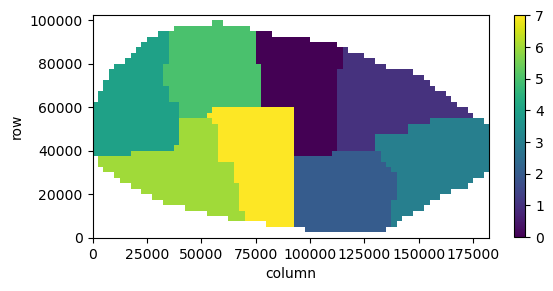

In [13]:
mfsplit = Mf6Splitter(base_sim)

use_metis = True
if use_metis:
 split_array = mfsplit.optimize_splitting_mask(nparts=nr_domains)
else:
  split_array = np.zeros((nrow, ncol), dtype=int)
  for irow in range(nrow):
    for icol in range(ncol):      
      isub = np.floor(icol / (ncol / nr_domains))
      split_array[irow, icol] = isub

pmv = flopy.plot.PlotMapView(model=gwf, layer=0)
pa = pmv.plot_array(split_array)
pmv.plot_inactive(color_noflow="white")
plt.ylabel("row")
plt.xlabel("column")
plt.colorbar(pa, shrink=0.6)

In [14]:
parallel_sim = mfsplit.split_model(split_array)
models = [parallel_sim.get_model(mname) for mname in parallel_sim.model_names]

In [15]:
partition_data = [[m.name, i] for i, m in enumerate(models)]
hpc = flopy.mf6.ModflowUtlhpc(parallel_sim, partitions=partition_data)

In [16]:

parallel_sim.set_sim_path(parallel_dir)
parallel_sim.write_simulation()
mfsplit.save_node_mapping(parallel_dir / "mfsplit_node_mapping.json")

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing package sim_0_1.gwfgwf...
  writing package sim_0_2.gwfgwf...
  writing package sim_0_5.gwfgwf...
  writing package sim_0_7.gwfgwf...
  writing package sim_1_2.gwfgwf...
  writing package sim_1_3.gwfgwf...
  writing package sim_2_3.gwfgwf...
  writing package sim_2_7.gwfgwf...
  writing package sim_4_5.gwfgwf...
  writing package sim_4_6.gwfgwf...
  writing package sim_5_6.gwfgwf...
  writing package sim_5_7.gwfgwf...
  writing package sim_6_7.gwfgwf...
  writing package sim.hpc...
  writing model model_0...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package river...
    writing package gwd...
    writing package oc...
  writing model model_1...
    writing model name file...
    writing package dis...
    writing package ic...
    writing 

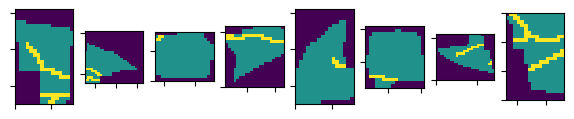

In [17]:
fig = plt.figure(figsize=(figwidth, 0.55*figheight))

for i,m in enumerate(parallel_sim.model_names):
  ax = fig.add_subplot(1,nr_domains,i+1)
  pmv = flopy.plot.PlotMapView(models[i])
  idomain = models[i].modelgrid.idomain
  pmv.plot_array(idomain[0], vmax=2)
  
  ax.set_xticklabels([])
  ax.set_yticklabels([])



In [18]:
for m in models:
  idomain = m.modelgrid.idomain
  print(f"Nr. of active cells in {m.name}:", np.count_nonzero(idomain))
  

Nr. of active cells in model_0: 1300
Nr. of active cells in model_1: 1300
Nr. of active cells in model_2: 1300
Nr. of active cells in model_3: 1305
Nr. of active cells in model_4: 1300
Nr. of active cells in model_5: 1305
Nr. of active cells in model_6: 1300
Nr. of active cells in model_7: 1305
